<a href="https://colab.research.google.com/github/astridyusiang-pixel/Mini-Projects/blob/main/CRC_proteomics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn


In [4]:
import pandas as pd

expression_df = pd.read_csv('/content/Protein Matrix.txt', sep='\t', index_col=0)


sample_info_df = pd.read_csv('/content/Sample_classification.txt', sep='\t')

print("Expression matrix shape:", expression_df.shape)
print("Sample info columns:", sample_info_df.columns)
print(sample_info_df.head())


Expression matrix shape: (4770, 276)
Sample info columns: Index(['Name', 'Dataset', 'Tissue', 'Organ'], dtype='object')
               Name    Dataset Tissue  Organ
0  ppb.iBAQ.Tumor.8  PXD001676  Tumor  Colon
1  ppb.iBAQ.Tumor.7  PXD001676  Tumor  Colon
2  ppb.iBAQ.Tumor.6  PXD001676  Tumor  Colon
3  ppb.iBAQ.Tumor.5  PXD001676  Tumor  Colon
4  ppb.iBAQ.Tumor.4  PXD001676  Tumor  Colon


In [5]:

sample_columns = expression_df.columns[2:]
expression_df_samples = expression_df[sample_columns]


expression_df_samples = expression_df_samples.T
print("Expression samples shape:", expression_df_samples.shape)
print(expression_df_samples.head())


Expression samples shape: (274, 4770)
Gene ID                      ENSG00000121410  ENSG00000148584  \
ppb.iBAQ.17AT_S1_10R1_CRC5T     4.514480e+05              NaN   
ppb.iBAQ.17AT_S1_11R1_CRC5N     9.175208e+05              NaN   
ppb.iBAQ.17AT_S1_12R1_CRC6T     1.388975e+06              NaN   
ppb.iBAQ.17AT_S1_13R1_CRC6N     3.546152e+05      2597.381808   
ppb.iBAQ.17AT_S1_14R1_CRC7T     5.708428e+05              NaN   

Gene ID                      ENSG00000175899  ENSG00000166535  \
ppb.iBAQ.17AT_S1_10R1_CRC5T     4.091689e+05              NaN   
ppb.iBAQ.17AT_S1_11R1_CRC5N     7.739523e+05      6797.922751   
ppb.iBAQ.17AT_S1_12R1_CRC6T     2.335360e+06              NaN   
ppb.iBAQ.17AT_S1_13R1_CRC6N     8.801530e+05              NaN   
ppb.iBAQ.17AT_S1_14R1_CRC7T     2.446139e+05              NaN   

Gene ID                      ENSG00000094914  ENSG00000081760  \
ppb.iBAQ.17AT_S1_10R1_CRC5T     46866.851511              NaN   
ppb.iBAQ.17AT_S1_11R1_CRC5N      9513.116459      

In [24]:
print(sample_info_df.columns)



Index(['Dataset', 'Tissue', 'Organ'], dtype='object')


In [26]:

common_samples = expression_df_samples.index.intersection(sample_info_df.index)


expression_df_samples = expression_df_samples.loc[common_samples]
sample_info_df = sample_info_df.loc[common_samples]


labels = sample_info_df['Tissue'].map(lambda x: 1 if x=='Tumor' else 0)
print(labels.value_counts())



Tissue
1    143
0    131
Name: count, dtype: int64


In [27]:
print(sample_info_df['Tissue'].unique())


['Tumor' 'Mucosa' 'Adenoma']


In [28]:
# Map labels: Tumor = 1, Mucosa/Adenoma = 0
labels = sample_info_df['Tissue'].map(lambda x: 1 if x == 'Tumor' else 0)
print(labels.value_counts())


Tissue
1    143
0    131
Name: count, dtype: int64


In [29]:

expression_df_samples = expression_df_samples.fillna(0)


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(expression_df_samples)


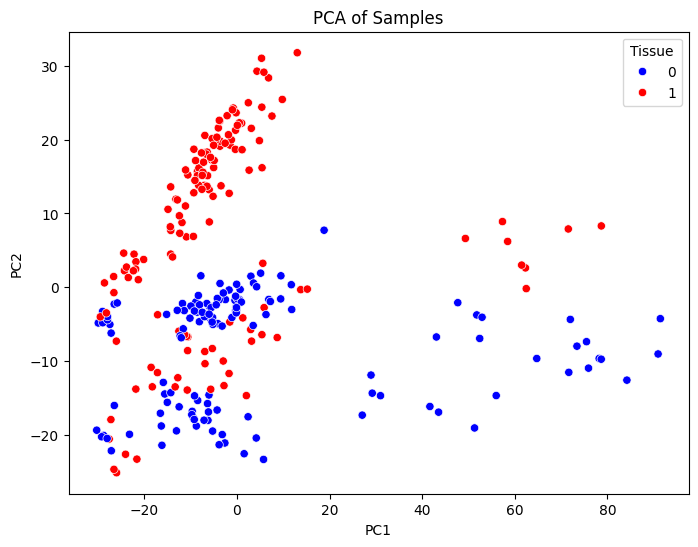

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette={0:'blue',1:'red'})
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Samples')
plt.show()


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)


Test Accuracy: 0.9818181818181818
ROC AUC: 1.0


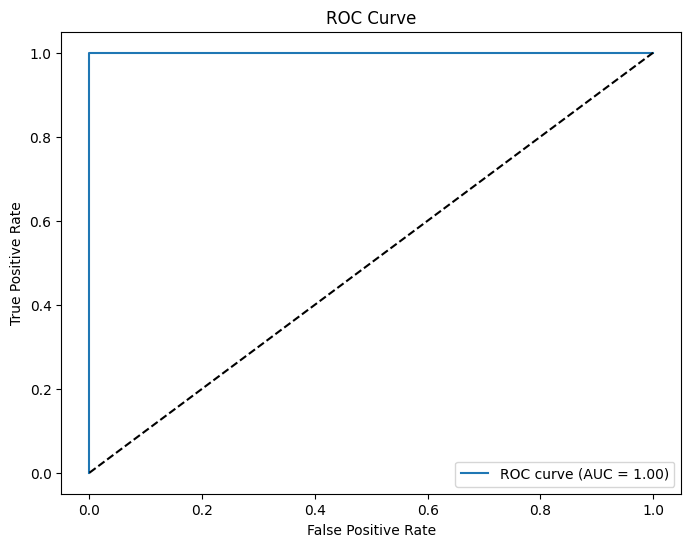

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict probabilities
y_prob = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print("Test Accuracy:", accuracy)
print("ROC AUC:", roc_auc)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [35]:
import numpy as np

# Coefficients of logistic regression
coef = clf.coef_[0]
top_idx = np.argsort(np.abs(coef))[::-1][:20]  # top 20 proteins

top_features = expression_df_samples.columns[top_idx]
top_coefs = coef[top_idx]

for f, c in zip(top_features, top_coefs):
    print(f"{f}: {c:.4f}")


ENSG00000116489: 0.0520
ENSG00000133742: -0.0463
ENSG00000131174: 0.0453
ENSG00000182871: 0.0452
ENSG00000151348: -0.0449
ENSG00000121691: -0.0442
ENSG00000189221: -0.0435
ENSG00000175220: 0.0434
ENSG00000115414: 0.0430
ENSG00000179163: -0.0422
ENSG00000177697: 0.0420
ENSG00000153487: 0.0420
ENSG00000115850: -0.0415
ENSG00000163347: 0.0412
ENSG00000176387: -0.0410
ENSG00000163586: -0.0410
ENSG00000179820: -0.0404
ENSG00000121053: 0.0394
ENSG00000111711: 0.0394
ENSG00000166165: -0.0393


Conclusion

The CRC proteomics dataset has been successfully cleaned and aligned, with 143 Tumor and 131 Non-tumor samples. Tissue types were mapped to binary labels, and only samples present in both the expression matrix and sample information were retained. The dataset is now ready for downstream analysis, including dimensionality reduction and classification modeling, ensuring reliable and accurate results.
